## PYMUPDF

In [50]:
import os
os.environ['API_KEY'] = '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'

In [2]:
# !pip install groq chardet pymupdf

In [51]:
import os
import csv
import json
from typing import List, Dict, Any
import fitz  # PyMuPDF
from groq import Groq
import pandas as pd
import chardet

# Initialize Groq client
client = Groq(api_key=os.getenv("API_KEY"))

def groq_response(question):
    response = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": question,
            }
        ],
        model="llama-3.1-8b-instant",
        temperature=0.2,
        max_tokens=100,
    )
    return response.choices[0].message.content


def extract_text_from_pdf(pdf_path: str) -> str:
    """Extract text from a PDF file."""
    try:
        doc = fitz.open(pdf_path)
        text = ""
        for page in doc:
            text += page.get_text()
        return text
    except Exception as e:
        print(f"Error extracting text from PDF {pdf_path}: {str(e)}")
        return ""

def read_file_with_auto_detect(file_path):
    """Read a file with automatic encoding detection."""
    with open(file_path, 'rb') as file:
        raw_data = file.read()
    
    detected = chardet.detect(raw_data)
    encodings = [detected['encoding'], 'utf-8', 'latin-1', 'ascii']
    
    for encoding in encodings:
        try:
            return raw_data.decode(encoding)
        except UnicodeDecodeError:
            continue
    
    # If all else fails, return the raw bytes as a string
    return str(raw_data)


def detect_circular_endorsements(user_id: str, recommender_ids: List[str], endorsement_data: Dict[str, List[str]]) -> List[str]:
    """Detect circular endorsements."""
    circular_endorsements = []
    for recommender_id in recommender_ids:
        if recommender_id in endorsement_data:
            if user_id in endorsement_data[recommender_id]:
                circular_endorsements.append(recommender_id)
    return circular_endorsements

def load_endorsement_data(csv_path: str) -> Dict[str, List[str]]:
    """Load endorsement data from CSV file."""
    endorsement_data = {}
    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header
        for row in reader:
            user_id, recommenders = row
            endorsement_data[user_id] = json.loads(recommenders.replace("'", '"'))
    return endorsement_data


In [4]:
# Base directories
resumes_dir = "/kaggle/input/innov8-finals/Dataset/Final_Resumes"
recommendations_base_dir = "/kaggle/input/innov8-finals/Dataset/Final_Recommendation_Letters"


In [5]:
recommendation_texts = {}

In [6]:
endorsement_data = load_endorsement_data("/kaggle/input/innov8-finals/Dataset/Final_Persons_And_Recommenders.csv")

In [7]:
endorsement_data['194']

[889, 3, 804, 796, 428]

In [8]:
for user_id in endorsement_data.keys():
    recommendation_dir = os.path.join(recommendations_base_dir, f"Recommendation_Letters_of_ID_{user_id}")
    
    recommendation_paths = {f.split('.')[0].split('_')[-1]:os.path.join(recommendation_dir, f) for f in os.listdir(recommendation_dir) if f.endswith('.txt')}
    recommendation_text = {key:read_file_with_auto_detect(path) for key,path in recommendation_paths.items()}
    
    recommendation_texts[user_id] = recommendation_text

In [9]:
resume_texts = {}
for user_id in [str(i) for i in range(1000)]:
    resume_path = os.path.join(resumes_dir, f"Resume_of_ID_{user_id}.pdf")
    if os.path.exists(resume_path):
        resume_text = extract_text_from_pdf(resume_path)
    else:
        resume_text = ""
    resume_texts[user_id] = resume_text

In [10]:
len(resume_texts)

1000

In [11]:
import pandas as pd
df = pd.read_csv("/kaggle/input/resume-summaries/resume_summaries.csv")
df.sort_values('User ID',ascending=True,inplace=True)
resume_summaries = df['Resume Summary'].tolist()

In [12]:
output = pd.DataFrame(columns=['ID', 'Resume Summary', 'Recommendation Letter Score', 'Resume Score', 'Suspicious Wording Score'])

In [13]:
output['ID'] = [str(i) for i in range(1000)]
output['Resume Summary'] = resume_summaries

In [14]:
# for i in range(1000):
#     user_id = str(i)
#     if user_id in endorsement_data:
#         recommendation_score = 0
#         for recommender_id, recommendation_letter in recommendation_texts[user_id].items():
#             recommendation_score += int(groq_response(prompt_for_grading_recommendation_letter.format(resume_candidate=resume_summaries[int(user_id)], recommendation_letter=recommendation_letter, resume_recommender=resume_summaries[int(recommender_id)])))
        
#         recommendation_score = recommendation_score / len(recommendation_texts[user_id])
        
#         resume_score = int(groq_response(prompt_for_resume_score_based_on_recommendation.format(resume_candidate = resume_summaries[int(user_id)], recommendation_letters='\n'.join(list(recommendation_texts[user_id].values())))))
#         output.loc[output['ID'] == user_id, 'Recommendation Letter Score'] = recommendation_score
#         output.loc[output['ID'] == user_id, 'Resume Score'] = resume_score
#     else:
#         output.loc[output['ID'] == user_id, 'Recommendation Letter Score'] = None
#         output.loc[output['ID'] == user_id, 'Resume Score'] = None
    
#     output.loc[output['ID'] == user_id, 'Suspicious Wording Score'] = int(groq_response(prompt_for_suspicious_wording.format(resume_text= resume_summaries[int(user_id)])))

#     print(f"Processed user {user_id}")
    


In [15]:
# suspicious_wording_score = groq_response(prompt_for_suspicious_wording.format(resume_text=resume_summary_candidate))

In [16]:
# user_id = '0'
# recommendation_letters_text = "\n".join(recommendation_texts[user_id].values())

In [17]:
# for user_id in [str(i) for i in range(10)]:
#     resume_score = groq_response(prompt_for_resume_score_based_on_recommendation.format(resume_candidate=resume_summary_candidate, recommendation_letters=recommendation_letters_text))

## Populate the code

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

G_recommendations = nx.DiGraph()
G_recommendations.add_nodes_from([str(i) for i in range(1000)])

In [19]:
for user_id, recommender_ids in endorsement_data.items():
    for recommender_id in recommender_ids:
        G_recommendations.add_edge(user_id,str(recommender_id))

In [20]:
list(G_recommendations.successors('3'))

['194', '122']

### Cycles of each size

In [21]:
# Dictionary to store the number of cycles of different sizes for each node
node_cycle_count = {i: {2: 0, 3: 0, 4: 0, 5: 0} for i in G_recommendations.nodes()}

# Function to find cycles of length 2-5
def find_cycles_of_size_2_to_5(G):
    # Iterate over each node
    for i in G.nodes():
        # For 2-length cycles
        for j in G.successors(i):  # Neighbors that i points to
            if G.has_edge(j, i):  # If j points back to i, we have a 2-cycle
                node_cycle_count[i][2] += 1
        
        # For 3-length cycles
        for j in G.successors(i):  # Neighbors that i points to
            for k in G.successors(j):  # Neighbors that j points to
                if G.has_edge(k, i):  # If k points back to i, we have a 3-cycle
                    node_cycle_count[i][3] += 1
        
        # For 4-length cycles
        for j in G.successors(i):  # Neighbors that i points to
            for k in G.successors(j):  # Neighbors that j points to
                for l in G.successors(k):  # Neighbors that k points to
                    if G.has_edge(l, i):  # If l points back to i, we have a 4-cycle
                        node_cycle_count[i][4] += 1
        
        # For 5-length cycles
        for j in G.successors(i):  # Neighbors that i points to
            for k in G.successors(j):  # Neighbors that j points to
                for l in G.successors(k):  # Neighbors that k points to
                    for m in G.successors(l):  # Neighbors that l points to
                        if G.has_edge(m, i):  # If m points back to i, we have a 5-cycle
                            node_cycle_count[i][5] += 1

# Call the function to find cycles of size 2-5
find_cycles_of_size_2_to_5(G_recommendations)

In [22]:
max_cycles = {'2':0,'3':0,'4':0,'5':0}
recommendation_redundancy_score = {}
for key, cycles_dict in node_cycle_count.items():
    for cycle_length, count in cycles_dict.items():
        if count > max_cycles[str(cycle_length)]:
            max_cycles[str(cycle_length)] = count

In [23]:
max_cycles

{'2': 2, '3': 3, '4': 7, '5': 25}

In [24]:
weights_for_each_cycle_length = [1/i/sum([1/i for i in range(2,6)]) for i in range(2,6)]
weights_for_each_cycle_length

[0.38961038961038963,
 0.25974025974025977,
 0.19480519480519481,
 0.15584415584415587]

In [25]:
recommendation_redundancy_score = {}

for key, cycles_dict in node_cycle_count.items():
    recommendation_redundancy_score[key] = sum([count*w/max_cycles[str(cycle_length)] for (cycle_length, count),w in zip(cycles_dict.items(),weights_for_each_cycle_length)])

In [26]:
max(recommendation_redundancy_score.values())

0.7956709956709958

In [27]:
# !pip install leidenalg igraph

In [30]:
# !pip install pycairo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.5/661.5 kB 7.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycairo: filename=pycairo-1.27.0-cp310-cp310-linux_x86_64.whl size=130690 sha256=4a317461576743cde61d6672263a0f89b26d669d5100f47a9f8760bb6c13bbba
  Stored in directory: /root/.cache/pip/wheels/c3/76/e4/134a2e849a3082926653cb544793d9642aed12399436f422d1
Successfully built pycairo


### Use Leiden Algorithm for community detection based on just recommendations

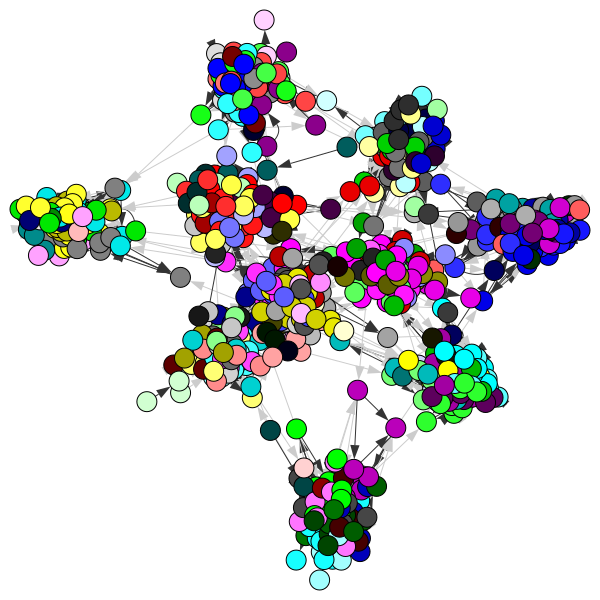

In [28]:
# Convert the networkx graph to an igraph graph
import networkx as nx
import igraph as ig
import leidenalg as la
import matplotlib.pyplot as plt
# Add edges to the directed graph
# Convert the networkx graph to an igraph graph using to_numpy_array
G_ig = ig.Graph.Adjacency((nx.to_numpy_array(G_recommendations) > 0).tolist())
G_ig = G_ig.as_directed()  # Ensure the graph is directed

# Apply the Leiden algorithm for community detection
partitions = la.find_partition(G_ig, la.CPMVertexPartition,
                                   resolution_parameter = 0.05)
ig.plot(partitions) 

In [29]:
len(partitions)

137

In [30]:
node_belongs_to_partition = {}
for i,partition in enumerate(partitions):
    for node in partition:
        node_belongs_to_partition[str(node)] = i

1. Community mean fraud score = sum of fraud scores of all nodes/ size of community
2. community resume score = sum of resume/ sizeof community

### Update using college information

In [31]:
prompt_for_college_information = """You are an expert in extracting structured data from resume summaries. Your task is to carefully analyze the provided **resume summary** of the candidate and return a structured list containing information about the colleges the candidate has studied in.

### Instructions:
1. Extract the **college names** that the candidate has studied in and mentioned that in resume.
4. Return the information in the form of a list of names of those colleges. If the name of college is not mentioned or a vague name is written, use "unknown college"

### Format of the Output:
The output should be ONLY a Python-style, like the one below and no additional information:
['MIT','Oxford','University of Pennsylvinia']

The output should contain not additional details or explanation for the answer.

### Resume Summary:
{resume_summary}
"""

In [32]:
G_updated = G_recommendations

In [33]:
fraction_for_testing_college_info = 1000

In [34]:
college_names = set()
candi_college_info = []

In [52]:
for i in range(957,1000):
    user_id = str(i)
    college_information = groq_response(prompt_for_college_information.format(resume_summary=resume_summaries[i]))
    college_information=college_information.replace("  "," ").replace("\'","").strip('[]').replace(', ',',').split(',') if college_information != "" else None
    college_names.update(college_information)
    candi_college_info.append(college_information)
    print(f'processed user {user_id}')

processed user 957
processed user 958
processed user 959
processed user 960
processed user 961
processed user 962
processed user 963
processed user 964
processed user 965
processed user 966
processed user 967
processed user 968
processed user 969
processed user 970
processed user 971
processed user 972
processed user 973
processed user 974
processed user 975
processed user 976
processed user 977
processed user 978
processed user 979
processed user 980
processed user 981
processed user 982
processed user 983
processed user 984
processed user 985
processed user 986
processed user 987
processed user 988
processed user 989
processed user 990
processed user 991
processed user 992
processed user 993
processed user 994
processed user 995
processed user 996
processed user 997
processed user 998
processed user 999


In [64]:
candi_college_info[999]

['Florida International University']

In [69]:
list(G_recommendations.neighbors('61'))

['380', '492', '569', '205']

### Add the college related edges to graph to increase density of connections

In [ ]:
college_names.discard('unknown college')
count = 0
for clg_name in college_names:
    for i in range(1000):
        for j in range(i+1,1000):
            if clg_name in candi_college_info[i] and clg_name in candi_college_info[j]:
#                 count+=1
                # print(f'user{i,j} studied from {clg_name}')
                G_updated.add_edge(str(i),str(j))
                G_updated.add_edge(str(j),str(i))

# count

In [67]:
len(G_recommendations.edges())

7449

### Apply community detection again

In [70]:
G_ig = ig.Graph.Adjacency((nx.to_numpy_array(G_updated) > 0).tolist())
G_ig = G_ig.as_directed()  # Ensure the graph is directed

# Apply the Leiden algorithm for community detection
partitions = la.find_partition(G_ig, la.CPMVertexPartition,
                                   resolution_parameter = 0.05)
ig.plot(partitions) 

### Rank candidates based on influence using page rank

In [75]:
import networkx as nx

# 1. Most Influential Node: Based on PageRank for directed graphs
pagerank = nx.pagerank(G_updated)
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

# Extract the most influential node and ranking
most_influential_node = sorted_pagerank[0][0]
ranked_nodes = [node for node, score in sorted_pagerank]

print(f"Most Influential Node ID: {most_influential_node}")
# print(f"Ranking of Most Influential Nodes (based on PageRank): {ranked_nodes}")

# 2. Correlation/Similarity Score between nodes: Based on Jaccard Similarity for directed graphs

Most Influential Node ID: 374


### Adamic adar  and jaccard index to find similarity between nodes

In [93]:
def adamic_adar_directed(G):
    adamic_scores = {}
    mean_score = 0
    for node1 in G.nodes():
        for node2 in G.nodes():
            if node1 != node2:
                # Use the predecessors (or use successors based on the problem)
                preds1 = set(G.predecessors(node1))
                preds2 = set(G.predecessors(node2))

                # Calculate Adamic-Adar score
                common_neighbors = preds1 & preds2
                score = sum(1 / nx.degree(G, common_neighbor) for common_neighbor in common_neighbors)
                adamic_scores[(node1, node2)] = score
                mean_score += score

    return adamic_scores, mean_score/1000000

In [87]:
def jaccard(G):
    jaccard_scores = {}
    max_similarity = -1
    for node1 in G.nodes():
        for node2 in G.nodes():
            if node1 != node2:
                # Use the predecessors (incoming connections) for similarity in directed graph
                preds1 = set(G.predecessors(node1))
                preds2 = set(G.predecessors(node2))

                # Calculate Jaccard similarity between the predecessors of node1 and node2
                intersection = len(preds1 & preds2)
                union = len(preds1 | preds2)
                similarity_score = intersection / union if union > 0 else 0

                jaccard_scores[(node1, node2)] = similarity_score
                
    return jaccard_scores

In [94]:
adamic_adar_scores, mean_score = adamic_adar_directed(G_updated)

In [95]:
mean_score

0.003396028015583406

In [92]:
adamic_adar_scores[('0','1')]

0

In [58]:
import pickle

# save graph object to file
pickle.dump(G_updated, open('graph.pickle', 'wb'))

In [ ]:
# # read pickle file
# import pickle
# with open('graph.pickle', 'rb') as f:
#     G_updated = pickle.load(f)